In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lmfit
import json
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import sqlite3
# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42
def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

import statsmodels.formula.api as smf

In [52]:
### NMR

all_fit_params = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/05_nmr_ntp_adduction/01.047.NMR_NTP_adduction_kinetics/data/peak_analysis/all_data_fitparams.csv'
nmr_ntp = pd.read_csv(all_fit_params)
nmr_ntp = nmr_ntp[nmr_ntp['peak'] == 'peak8']
nmr_ntp['base'] = nmr_ntp['ntp'].str[0]
nmr_ntp['method'] = 'nmr'
nmr_ntp['lnkadd_err'] = nmr_ntp['k1_err'] / nmr_ntp['k1']
nmr_ntp
nmr_ntp = nmr_ntp[['lnkadd', 'lnkadd_err', '1/T', 'base', 'method']]
nmr_ntp.columns = ['log_kobs', 'log_kobs_err', 'inv_temp', 'base', 'method']

In [53]:
# Load data

global_fits = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/06_aggfit_ntp_adduction/reference/EKC.01.061.analyze_fit_distributions/global_refit_results.db'

conn = sqlite3.connect(global_fits)
query = 'SELECT * FROM global_fits'
fits = pd.read_sql_query(query, conn)
fits

# get experimental info
main_db  = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/06_aggfit_ntp_adduction/reference/EKC.01.060.developing_DB_input/new.db'
conn = sqlite3.connect(main_db)
query = """
    SELECT pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id
    FROM reaction_groups rg
    JOIN constructs c ON pr.construct_id = c.id
    LEFT JOIN probing_reactions pr ON rg.rxn_id = pr.id
    WHERE pr.RT = 'MRT'
    GROUP BY rg.rg_id
"""
exp_info = pd.read_sql_query(query, conn)
fits['rg_id'] = fits['rg_id'].astype(int)
fits = fits.merge(exp_info, left_on='rg_id', right_on='rg_id', how='left')

# drop duplicates
fits = fits.drop_duplicates()
# filter fits to under 85C
fits = fits[fits['temperature'] < 85]

site = 18
fits_filt18A = fits[(fits['disp_name'] == '4U_wt') & (fits['site'] == site)].copy()
fits_filt18A.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt18A['temperature'])
fits_filt18A.loc[:, 'log_kobs'] = fits_filt18A['log_kappa'] + fits_filt18A['log_kdeg']
fits_filt18A['base'] = 'A'
fits_filt18A['method'] = 'unpaired'
fits_filt18A['log_kobs_err'] = fits_filt18A['stderr_log_kappa'] + fits_filt18A['stderr_log_kdeg']
fits_filt18A = fits_filt18A[['log_kobs', 'log_kobs_err', 'inv_temp', 'base', 'method']]


# plot C
site = 24
fits_filt24C = fits[(fits['disp_name'] == 'hiv_a35g') & (fits['site'] == site)].copy()
fits_filt24C.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt24C['temperature'])
fits_filt24C.loc[:, 'log_kobs'] = fits_filt24C['log_kappa'] + fits_filt24C['log_kdeg']
fits_filt24C['base'] = 'C'
fits_filt24C['method'] = 'unpaired'
fits_filt24C['log_kobs_err'] = fits_filt24C['stderr_log_kappa'] + fits_filt24C['stderr_log_kdeg']
fits_filt24C = fits_filt24C[['log_kobs', 'log_kobs_err', 'inv_temp', 'base', 'method']]

# plot G
site = 19
fits_filt19G = fits[(fits['disp_name'] == '4U_wt') & (fits['site'] == site)].copy()
fits_filt19G.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt19G['temperature'])
fits_filt19G.loc[:, 'log_kobs'] = fits_filt19G['log_kappa'] + fits_filt19G['log_kdeg']
fits_filt19G['base'] = 'G'
fits_filt19G['method'] = 'unpaired'
fits_filt19G['log_kobs_err'] = fits_filt19G['stderr_log_kappa'] + fits_filt19G['stderr_log_kdeg']
fits_filt19G = fits_filt19G[['log_kobs', 'log_kobs_err', 'inv_temp', 'base', 'method']]

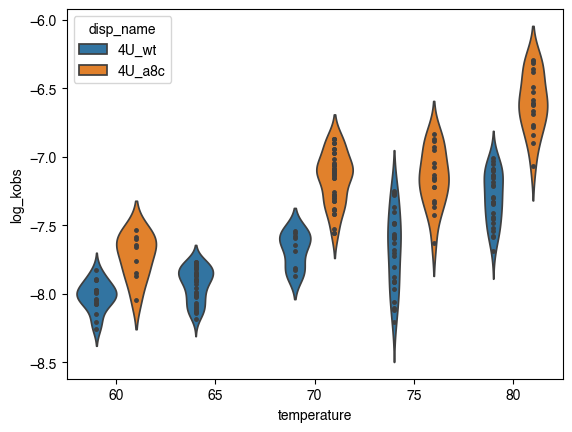

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_65876/555255084.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  agg_values_df = pd.concat([agg_values_df, to_append], ignore_index=True)


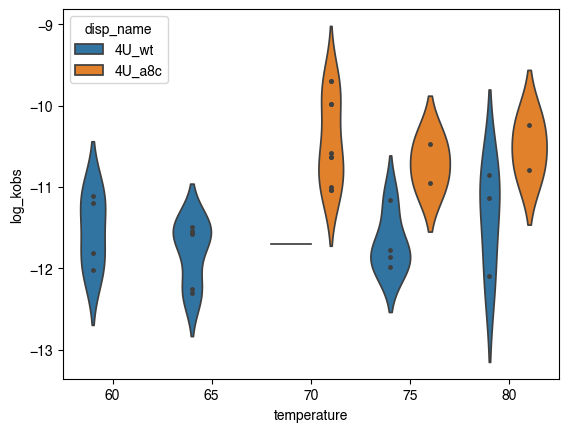

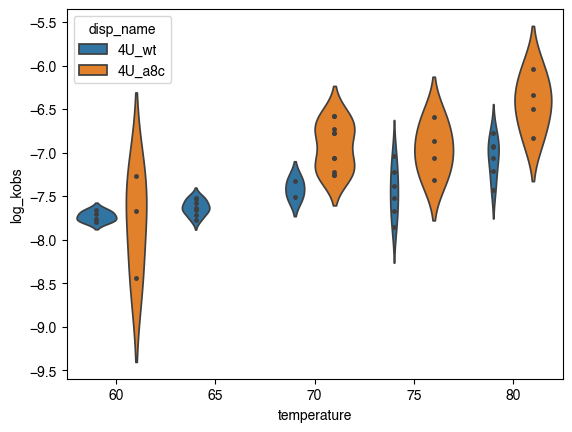

In [54]:
agg_values_df = pd.DataFrame(columns=['log_kobs', 'log_kobs_err', 'inv_temp', 'base', 'method'])

sites_dict = {'A': [7, 15, 16, 18, 22, 26, 29, 34, 35], 'C': [9, 25], 'G': [19, 31]}

for base in ['A', 'G', 'C']:

    # base = 'A'
    data = fits[(fits['disp_name'].str.contains('4U_')) & (fits['temperature'] > 59) & (fits['site'].isin(sites_dict[base]))].copy()
    data.loc[:, 'inv_temp'] = 1/(273.15 + data['temperature'])
    data.loc[:, 'log_kobs'] = data['log_kappa'] + data['log_kdeg']

    # filter data greater than -8.5
    if (base == 'A') or (base == 'C'):    
        data = data[data['log_kobs'] > -8.5]

    sns.violinplot(data=data, x='temperature', y='log_kobs', hue = 'disp_name', split = False, inner='points')
    plt.show()
    #sns.boxplot(data=data, x='temperature', y='log_kobs', hue = 'disp_name')
    grouped = data.groupby(['disp_name', 'inv_temp'])['log_kobs'].agg(
        log_kobs='mean',
        log_kobs_err='sem'
    ).reset_index()

    grouped['base'] = base
    grouped['method'] = 'melted_agg'

    to_append = grouped[['log_kobs', 'log_kobs_err', 'inv_temp', 'base', 'method']].copy()
    
    agg_values_df = pd.concat([agg_values_df, to_append], ignore_index=True)

In [55]:
agg_values_df


,log_kobs,log_kobs_err,inv_temp,base,method
0,-6.601480,0.052007,0.002832,A,melted_agg
1,-7.150959,0.050606,0.002872,A,melted_agg
2,-7.154808,0.028526,0.002914,A,melted_agg
3,-7.727273,0.055382,0.003002,A,melted_agg
4,-7.297711,0.037017,0.002832,A,melted_agg
5,-7.673738,0.054766,0.002872,A,melted_agg
6,-7.678125,0.042766,0.002914,A,melted_agg
7,-7.929170,0.020835,0.002957,A,melted_agg
8,-8.016611,0.026057,0.003002,A,melted_agg
9,-10.511631,0.274475,0.002832,G,melted_agg


In [56]:
all_fits_kobs = pd.concat([nmr_ntp, fits_filt18A, fits_filt24C, fits_filt19G, agg_values_df], ignore_index=True).dropna()
all_fits_kobs_A = all_fits_kobs[all_fits_kobs['base'] == 'A']
all_fits_kobs_C = all_fits_kobs[all_fits_kobs['base'] == 'C']
all_fits_kobs_G = all_fits_kobs[all_fits_kobs['base'] == 'G']

In [57]:
all_fits_kobs_A

,log_kobs,log_kobs_err,inv_temp,base,method
0,-7.064601,0.117700,0.003411,A,nmr
1,-5.756667,0.034213,0.003224,A,nmr
2,-5.557570,0.047333,0.003224,A,nmr
3,-5.345155,0.147587,0.003173,A,nmr
4,-5.471566,0.120953,0.003173,A,nmr
5,-4.543482,0.126005,0.003114,A,nmr
17,-10.504412,0.007255,0.003354,A,unpaired
18,-9.215167,0.002201,0.003143,A,unpaired
19,-7.699289,0.031308,0.002872,A,unpaired
20,-7.541853,0.024884,0.002832,A,unpaired


In [58]:
# linear fit using lmfit

def fit_linear_model(data):
    model = lmfit.models.LinearModel()
    params = model.make_params(slope=-7800, intercept=20)
    weights = 1 / data['log_kobs_err']**2
    result = model.fit(data['log_kobs'], params, x=data['inv_temp'], weights=weights)

    # calculate r2
    y_mean = np.average(y, weights=w)
    ss_tot = np.sum(w * (y - y_mean)**2)
    ss_res = np.sum(w * (y - y_fit)**2)
    r2 = 1 - ss_res / ss_tot


    # return n_data, slope, slope_stdev, intercept, intercept_stdev
    num_data = result.ndata
    m = result.params['slope'].value
    m_stdev = result.params['slope'].stderr / np.sqrt(num_data)
    b = result.params['intercept'].value
    b_stdev = result.params['intercept'].stderr / np.sqrt(num_data)

    return num_data, m, m_stdev, b, b_stdev, result, r2

In [59]:
from scipy.stats import ttest_ind_from_stats

def calc_welch_stats(linfit_1, linfit_2):
    ndata_1, slope1, slope_stdev1, intercept1, intercept_stdev1, res1 = linfit_1
    ndata_2, slope2, slope_stdev2, intercept2, intercept_stdev2, res2 = linfit_2

    # Welch's t-test on slope
    t_stat_m, p_val_m = ttest_ind_from_stats(
        mean1 = slope1, std1 = slope_stdev1, nobs1 = ndata_1,
        mean2 = slope2, std2 = slope_stdev2, nobs2 = ndata_2,
        equal_var=False
    )

    # Welch's t-test on intercept
    t_stat_b, p_val_b = ttest_ind_from_stats(
        mean1 = intercept1, std1 = intercept_stdev1, nobs1 = ndata_1,
        mean2 = intercept2, std2 = intercept_stdev2, nobs2 = ndata_2,
        equal_var=False
    )
    return (t_stat_m, p_val_m), (t_stat_b, p_val_b)

nmr_A = fit_linear_model(all_fits_kobs_A[all_fits_kobs_A['method'] == 'nmr'])
unpaired_A = fit_linear_model(all_fits_kobs_A[all_fits_kobs_A['method'] == 'unpaired'])
melted_A = fit_linear_model(all_fits_kobs_A[all_fits_kobs_A['method'] == 'melted_agg'])
welch_A_slope, welch_A_int = calc_welch_stats(nmr_A, unpaired_A)

# p < 0.05 reject null that the slopes are equal (statistically different)
# p > 0.05 fail to reject null that the intercepts are equal (not statistically different)

# print t-test results
print(f"Welch's t-test for slopes (A): t-statistic = {welch_A_slope[0]:.3f}, p-value = {welch_A_slope[1]:.3f}")
print(f"Welch's t-test for intercepts (A): t-statistic = {welch_A_int[0]:.3f}, p-value = {welch_A_int[1]:.3f}")

nmr_C = fit_linear_model(all_fits_kobs_C[all_fits_kobs_C['method'] == 'nmr'])
unpaired_C = fit_linear_model(all_fits_kobs_C[all_fits_kobs_C['method'] == 'unpaired'])
melted_C = fit_linear_model(all_fits_kobs_C[all_fits_kobs_C['method'] == 'melted_agg'])
welch_C_slope, welch_C_int = calc_welch_stats(nmr_C, unpaired_C)

# print t-test results
print(f"Welch's t-test for slopes (C): t-statistic = {welch_C_slope[0]:.3f}, p-value = {welch_C_slope[1]:.3f}")
print(f"Welch's t-test for intercepts (C): t-statistic = {welch_C_int[0]:.3f}, p-value = {welch_C_int[1]:.3f}")

nmr_G = fit_linear_model(all_fits_kobs_G[all_fits_kobs_G['method'] == 'nmr'])
unpaired_G = fit_linear_model(all_fits_kobs_G[all_fits_kobs_G['method'] == 'unpaired'])
melted_G = fit_linear_model(all_fits_kobs_G[all_fits_kobs_G['method'] == 'melted_agg'])

ValueError: too many values to unpack (expected 6)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Parameters, minimize, report_fit


In [ ]:
def plot_global_linear_fit(all_fits_kobs, plot_filename=None):
    # Prepare the two datasets
    data_1 = all_fits_kobs[all_fits_kobs['method'] == 'melted_agg']
    data_2 = all_fits_kobs[all_fits_kobs['method'] == 'nmr']

    x_vals = [data_1['inv_temp'].values, data_2['inv_temp'].values]
    y_vals = [data_1['log_kobs'].values, data_2['log_kobs'].values]
    weights = [1 / data_1['log_kobs_err'].values**2, 1 / data_2['log_kobs_err'].values**2]

    # Global linear model: shared slope, separate intercepts
    def linear_dataset(params, i, x):
        slope = params['slope']
        intercept = params[f'intercept_{i+1}']
        return slope * x + intercept

    def objective(params, x_vals, y_vals, weights):
        nsets = len(y_vals)
        resid = []
        for i in range(nsets):
            model_y = linear_dataset(params, i, x_vals[i])
            resid.append((y_vals[i] - model_y) * np.sqrt(weights[i]))
        return np.concatenate(resid)

    # Initialize parameters
    fit_params = Parameters()
    fit_params.add('slope', value=-8000, vary=True)

    for i in range(2):  # two datasets
        fit_params.add(f'intercept_{i+1}', value=10.0)

    # Run minimization
    out = minimize(objective, fit_params, args=(x_vals, y_vals, weights))
    report_fit(out.params)
    
    # Plotting
    fig, ax = plt.subplots(figsize = (3, 3))
    colors = ['darkred', 'black']
    labels = ['DMS', 'NMR']

    for i in range(2):
        x = x_vals[i]
        y = y_vals[i]
        w = weights[i]
        y_fit = linear_dataset(out.params, i, x)

        ax.errorbar(x, y, yerr=1/np.sqrt(w), fmt='o', color=colors[i], label=labels[i])
        ax.plot(x, y_fit, '-', color=colors[i])

    formatter = FuncFormatter(thousands)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_ylabel(r'$\ln(k_{add})$')
    ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
    ax.legend(frameon = False)
    plt.tight_layout()

    if plot_filename:
        plt.savefig(plot_filename)

    plt.show()

    return out

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Parameters, minimize, report_fit

def plot_individual_linear_fits(all_fits_kobs, plot_filename = None):
    # Prepare the two datasets
    data_1 = all_fits_kobs[all_fits_kobs['method'] == 'melted_agg']
    data_2 = all_fits_kobs[all_fits_kobs['method'] == 'nmr']

    x_vals = [data_1['inv_temp'].values, data_2['inv_temp'].values]
    y_vals = [data_1['log_kobs'].values, data_2['log_kobs'].values]
    weights = [1 / data_1['log_kobs_err'].values**2, 1 / data_2['log_kobs_err'].values**2]

    # Individual linear model: separate slopes and intercepts
    def linear_dataset(params, i, x):
        slope = params[f'slope_{i+1}']
        intercept = params[f'intercept_{i+1}']
        return slope * x + intercept

    def objective(params, x_vals, y_vals, weights):
        resid = []
        for i in range(len(y_vals)):
            model_y = linear_dataset(params, i, x_vals[i])
            resid.append((y_vals[i] - model_y) * np.sqrt(weights[i]))
        return np.concatenate(resid)

    # Initialize parameters
    fit_params = Parameters()
    for i in range(2):  # two datasets
        fit_params.add(f'slope_{i+1}', value=-8000)
        fit_params.add(f'intercept_{i+1}', value=10.0)

    # Run minimization
    out = minimize(objective, fit_params, args=(x_vals, y_vals, weights))
    report_fit(out.params)

    # calculate r2 for each dataset
    r2_vals = []
    for i in range(2):
        y_mean = np.average(y_vals[i], weights=weights[i])
        ss_tot = np.sum(weights[i] * (y_vals[i] - y_mean)**2)
        ss_res = np.sum(weights[i] * (y_vals[i] - linear_dataset(out.params, i, x_vals[i]))**2)
        r2 = 1 - ss_res / ss_tot
        r2_vals.append(r2)

    # Plotting
    fig, ax = plt.subplots(figsize=(3, 3))
    colors = ['darkred', 'black']
    labels = ['DMS', 'NMR']

    for i in range(2):
        x = x_vals[i]
        y = y_vals[i]
        w = weights[i]
        y_fit = linear_dataset(out.params, i, x)

        ax.errorbar(x, y, yerr=1/np.sqrt(w), fmt='o', color=colors[i], label=labels[i])
        ax.plot(np.sort(x), linear_dataset(out.params, i, np.sort(x)), '-', color=colors[i])

    formatter = FuncFormatter(thousands)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_ylabel(r'$\ln(k_{add})$')
    ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
    ax.legend(frameon = False)
    plt.tight_layout()

    if plot_filename:
        plt.savefig(plot_filename)

    plt.show()

    return out, r2_vals

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


[[Variables]]
    slope:       -6074.80195 +/- 1190.00956 (19.59%) (init = -8000)
    intercept_1:  10.1881281 +/- 3.48958711 (34.25%) (init = 10)
    intercept_2:  13.9031950 +/- 3.84074992 (27.62%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept_1)       = -0.9998
    C(slope, intercept_2)       = -0.9991
    C(intercept_1, intercept_2) = +0.9989


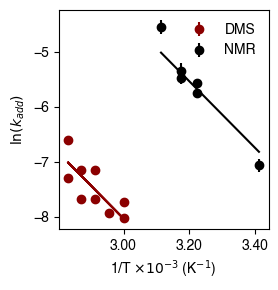

In [ ]:
out_global = plot_global_linear_fit(all_fits_kobs_A, 'A_linear_fit_global.pdf')

In [ ]:
import pandas as pd
from scipy import constants

def extract_arrhenius_params(out):
    R_kcal_per_mol_K = constants.R / 4184  # kcal/(mol·K)

    results = []
    for i, label in enumerate(['melted_agg', 'nmr']):
        slope = out.params[f'slope_{i+1}'].value
        slope_err = out.params[f'slope_{i+1}'].stderr
        intercept = out.params[f'intercept_{i+1}'].value
        intercept_err = out.params[f'intercept_{i+1}'].stderr

        ea = -slope * R_kcal_per_mol_K
        ea_err = slope_err * R_kcal_per_mol_K if slope_err is not None else None

        lnA = intercept
        lnA_err = intercept_err

        results.append({
            'group': label,
            'ea': ea,
            'ea_err': ea_err,
            'lnA': lnA,
            'lnA_err': lnA_err
        })

    df = pd.DataFrame(results)
    return df

def extract_arrhenius_params_global(out):
    R_kcal_per_mol_K = constants.R / 4184  # kcal/(mol·K)

    results = []
    for i, label in enumerate(['melted_agg', 'nmr']):
        slope = out.params[f'slope'].value
        slope_err = out.params[f'slope'].stderr
        intercept = out.params[f'intercept_{i+1}'].value
        intercept_err = out.params[f'intercept_{i+1}'].stderr

        ea = -slope * R_kcal_per_mol_K
        ea_err = slope_err * R_kcal_per_mol_K if slope_err is not None else None

        lnA = intercept
        lnA_err = intercept_err

        results.append({
            'group': label,
            'ea': ea,
            'ea_err': ea_err,
            'lnA': lnA,
            'lnA_err': lnA_err
        })

    df = pd.DataFrame(results)
    return df

[[Variables]]
    slope_1:     -5817.00716 +/- 1313.38615 (22.58%) (init = -8000)
    intercept_1:  9.43232981 +/- 3.85127255 (40.83%) (init = 10)
    slope_2:     -7827.40528 +/- 3424.50013 (43.75%) (init = -8000)
    intercept_2:  19.5548070 +/- 11.0441999 (56.48%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope_2, intercept_2) = -0.9999
    C(slope_1, intercept_1) = -0.9998


AttributeError: Line2D.set() got an unexpected keyword argument 's'

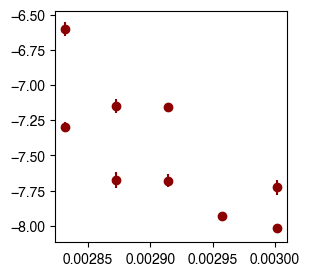

In [ ]:
out = plot_individual_linear_fits(all_fits_kobs_A, 'A_linear_fit_individual.pdf')
print(out)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


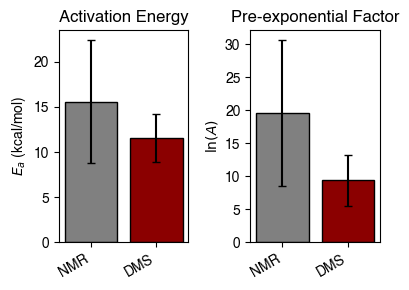

In [ ]:
df_arrhenius = extract_arrhenius_params(out)

# Map groups to display names and colors
group_labels = {
    'nmr': 'NMR',
    'melted_agg': 'DMS',
    '4U_a8c': 'DMS (4U A8C)'
}
colors = {
    'nmr': 'gray',
    'melted_agg': '#8B0000',   # dark red
    '4U_a8c': '#CD5C5C'   # indian red / lighter red
}

# Set 'group' as the index for easier access
df_arrhenius = df_arrhenius.set_index('group')

# Define group order for plotting
groups = ['nmr', 'melted_agg']
x = range(len(groups))

fig, axs = plt.subplots(1, 2, figsize=(4, 3), sharey=False)

# Ea bar plot
axs[0].bar(
    x,
    df_arrhenius.loc[groups, 'ea'],
    yerr=df_arrhenius.loc[groups, 'ea_err'],
    capsize=3,
    edgecolor='black',
    color=[colors[g] for g in groups]
)
axs[0].set_title('Activation Energy')
axs[0].set_ylabel(r'$E_a$ (kcal/mol)')
axs[0].set_xticks(x)
axs[0].set_xticklabels([group_labels[g] for g in groups], rotation=30, ha='right')

# lnA bar plot
axs[1].bar(
    x,
    df_arrhenius.loc[groups, 'lnA'],
    yerr=df_arrhenius.loc[groups, 'lnA_err'],
    capsize=3,
    edgecolor='black',
    color=[colors[g] for g in groups]
)
axs[1].set_title('Pre-exponential Factor')
axs[1].set_ylabel(r'$\ln(A)$')
axs[1].set_xticks(x)
axs[1].set_xticklabels([group_labels[g] for g in groups], rotation=30, ha='right')

plt.tight_layout()
plt.savefig('A_arrhenius_barplot_free.pdf')
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


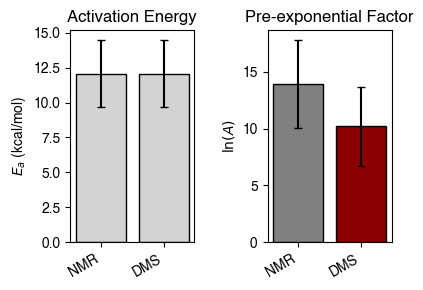

In [ ]:
df_arrhenius = extract_arrhenius_params_global(out_global)

# Map groups to display names and colors
group_labels = {
    'nmr': 'NMR',
    'melted_agg': 'DMS',
    '4U_a8c': 'DMS (4U A8C)'
}
colors = {
    'nmr': 'gray',
    'melted_agg': '#8B0000',   # dark red
    '4U_a8c': '#CD5C5C'   # indian red / lighter red
}

# Set 'group' as the index for easier access
df_arrhenius = df_arrhenius.set_index('group')

# Define group order for plotting
groups = ['nmr', 'melted_agg']
x = range(len(groups))

fig, axs = plt.subplots(1, 2, figsize=(4, 3), sharey=False)

# Ea bar plot
axs[0].bar(
    x,
    df_arrhenius.loc[groups, 'ea'],
    yerr=df_arrhenius.loc[groups, 'ea_err'],
    capsize=3,
    edgecolor='black',
    color='lightgray'
)
axs[0].set_title('Activation Energy')
axs[0].set_ylabel(r'$E_a$ (kcal/mol)')
axs[0].set_xticks(x)
axs[0].set_xticklabels([group_labels[g] for g in groups], rotation=30, ha='right')

# lnA bar plot
axs[1].bar(
    x,
    df_arrhenius.loc[groups, 'lnA'],
    yerr=df_arrhenius.loc[groups, 'lnA_err'],
    capsize=3,
    edgecolor='black',
    color=[colors[g] for g in groups]
)
axs[1].set_title('Pre-exponential Factor')
axs[1].set_ylabel(r'$\ln(A)$')
axs[1].set_xticks(x)
axs[1].set_xticklabels([group_labels[g] for g in groups], rotation=30, ha='right')

plt.tight_layout()
plt.savefig('A_arrhenius_barplot_global.pdf')
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


[[Variables]]
    slope:       -10151.6980 +/- 966.783486 (9.52%) (init = -8000)
    intercept_1:  22.4979493 +/- 2.86644167 (12.74%) (init = 10)
    intercept_2:  27.2910490 +/- 3.15628555 (11.57%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept_2)       = -0.9994
    C(slope, intercept_1)       = -0.9993
    C(intercept_1, intercept_2) = +0.9987


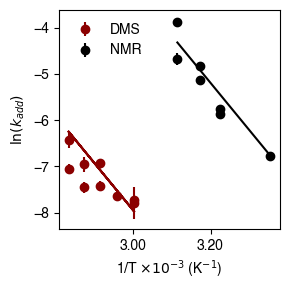

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


[[Variables]]
    slope_1:     -4831.14981 +/- 1839.23367 (38.07%) (init = -8000)
    intercept_1:  6.73451781 +/- 5.44983667 (80.92%) (init = 10)
    slope_2:     -11189.8226 +/- 812.425342 (7.26%) (init = -8000)
    intercept_2:  30.6783064 +/- 2.65210063 (8.64%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope_1, intercept_1) = -0.9999
    C(slope_2, intercept_2) = -0.9995


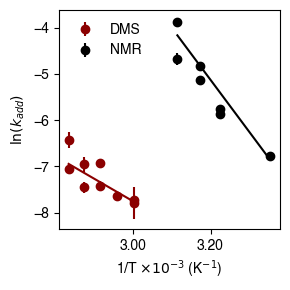

In [ ]:
out_global_C = plot_global_linear_fit(all_fits_kobs_C, 'C_linear_fit_global.pdf')
plot_individual_linear_fits(all_fits_kobs_C, 'C_linear_fit_individual.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


[[Variables]]
    slope:       -13303.2298 +/- 1576.80128 (11.85%) (init = -8000)
    intercept_1:  27.5381868 +/- 4.60522727 (16.72%) (init = 10)
    intercept_2:  37.9408384 +/- 5.14936967 (13.57%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept_2)       = -1.0000
    C(slope, intercept_1)       = -0.9975
    C(intercept_1, intercept_2) = +0.9975


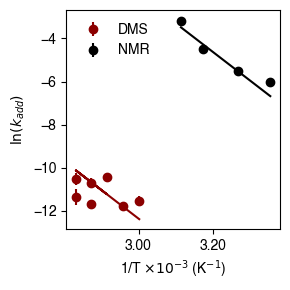

[[Variables]]
    slope_1:     -4500.11608 +/- 5595.54519 (124.34%) (init = -8000)
    intercept_1:  1.89094702 +/- 16.3048692 (862.26%) (init = 10)
    slope_2:     -13923.6226 +/- 1485.44867 (10.67%) (init = -8000)
    intercept_2:  39.9668450 +/- 4.85103666 (12.14%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope_2, intercept_2) = -1.0000
    C(slope_1, intercept_1) = -0.9998


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


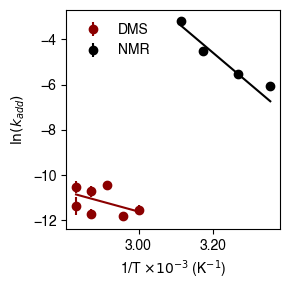

In [ ]:
out_global_G = plot_global_linear_fit(all_fits_kobs_G, 'G_linear_fit_global.pdf')
plot_individual_linear_fits(all_fits_kobs_G, 'G_linear_fit_individual.pdf')

[[Variables]]
    slope:       -7280.05638 +/- 175.821283 (2.42%) (init = -8000)
    intercept_1:  17.7897735 +/- 0.63645087 (3.58%) (init = 10)
    intercept_2:  13.7216721 +/- 0.53154350 (3.87%) (init = 10)
    intercept_3:  13.6687540 +/- 0.55951422 (4.09%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept_3)       = -0.9993
    C(slope, intercept_2)       = -0.9698
    C(intercept_2, intercept_3) = +0.9691
    C(slope, intercept_1)       = -0.8908
    C(intercept_1, intercept_3) = +0.8902
    C(intercept_1, intercept_2) = +0.8639


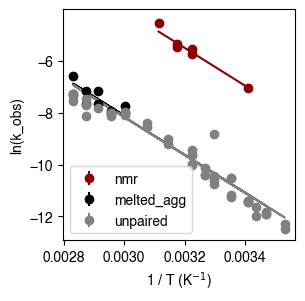

In [ ]:
# Prepare the three datasets
data_1 = all_fits_kobs_A[all_fits_kobs_A['method'] == 'nmr']
data_2 = all_fits_kobs_A[all_fits_kobs_A['method'] == 'melted_agg']
data_3 = all_fits_kobs_A[all_fits_kobs_A['method'] == 'unpaired']

x_vals = [data_1['inv_temp'].values, data_2['inv_temp'].values, data_3['inv_temp'].values]
y_vals = [data_1['log_kobs'].values, data_2['log_kobs'].values, data_3['log_kobs'].values]
weights = [1 / data_1['log_kobs_err'].values**2,
           1 / data_2['log_kobs_err'].values**2,
           1 / data_3['log_kobs_err'].values**2]

# Global linear model: shared slope, separate intercepts
def linear_dataset(params, i, x):
    slope = params['slope']
    intercept = params[f'intercept_{i+1}']
    return slope * x + intercept

def objective(params, x_vals, y_vals, weights):
    resid = []
    for i in range(len(y_vals)):
        model_y = linear_dataset(params, i, x_vals[i])
        resid.append((y_vals[i] - model_y) * np.sqrt(weights[i]))
    return np.concatenate(resid)

# Initialize parameters
fit_params = Parameters()
fit_params.add('slope', value=-8000, vary=True)

for i in range(3):  # three datasets
    fit_params.add(f'intercept_{i+1}', value=10.0)

# Run minimization
out = minimize(objective, fit_params, args=(x_vals, y_vals, weights))
report_fit(out.params)

# Plotting
fig, ax = plt.subplots(figsize=(3, 3))
colors = ['darkred', 'black', 'gray']
labels = ['nmr', 'melted_agg', 'unpaired']

for i in range(3):
    x = x_vals[i]
    y = y_vals[i]
    w = weights[i]
    y_fit = linear_dataset(out.params, i, x)

    ax.errorbar(x, y, yerr=1/np.sqrt(w), fmt='o', color=colors[i], label=labels[i])
    ax.plot(x, y_fit, '-', color=colors[i])

ax.set_xlabel('1 / T (K$^{-1}$)')
ax.set_ylabel('ln(k_obs)')
ax.legend()
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


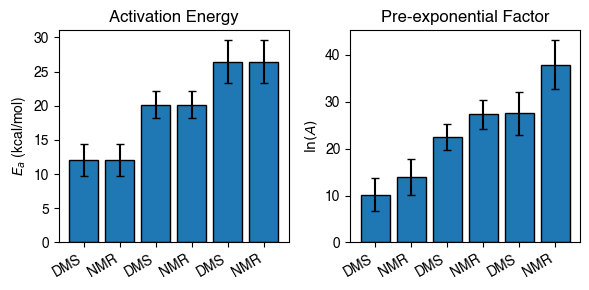

In [ ]:
df_global = pd.concat([extract_arrhenius_params_global(out_global), extract_arrhenius_params_global(out_global_C), extract_arrhenius_params_global(out_global_G)], ignore_index=True)
df_global['group'] = ['melted_A', 'nmr_A', 'melted_C', 'nmr_C', 'melted_G', 'nmr_G']

# Map groups to display names and colors
group_labels = {
    'melted_A': 'DMS',
    'nmr_A': 'NMR',
    'melted_C': 'DMS',
    'nmr_C': 'NMR',
    'melted_G': 'DMS',
    'nmr_G': 'NMR'
}
colors = {
    'nmr': 'gray',
    'melted_agg': '#8B0000',   # dark red
    '4U_a8c': '#CD5C5C'   # indian red / lighter red
}

# Set 'group' as the index for easier access
df_global = df_global.set_index('group')

# Define group order for plotting
groups = ['melted_A', 'nmr_A', 'melted_C', 'nmr_C', 'melted_G', 'nmr_G']
x = range(len(groups))

fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=False)

# Ea bar plot
axs[0].bar(
    x,
    df_global.loc[groups, 'ea'],
    yerr=df_global.loc[groups, 'ea_err'],
    capsize=3,
    edgecolor='black',
    #color=[colors[g] for g in groups]
)
axs[0].set_title('Activation Energy')
axs[0].set_ylabel(r'$E_a$ (kcal/mol)')
axs[0].set_xticks(x)
axs[0].set_xticklabels([group_labels[g] for g in groups], rotation=30, ha='right')

# lnA bar plot
axs[1].bar(
    x,
    df_global.loc[groups, 'lnA'],
    yerr=df_global.loc[groups, 'lnA_err'],
    capsize=3,
    edgecolor='black',
    #color=[colors[g] for g in groups]
)
axs[1].set_title('Pre-exponential Factor')
axs[1].set_ylabel(r'$\ln(A)$')
axs[1].set_xticks(x)
axs[1].set_xticklabels([group_labels[g] for g in groups], rotation=30, ha='right')

plt.tight_layout()
plt.savefig('global_arrhenius_barplot.pdf')
plt.show()

<Axes: >

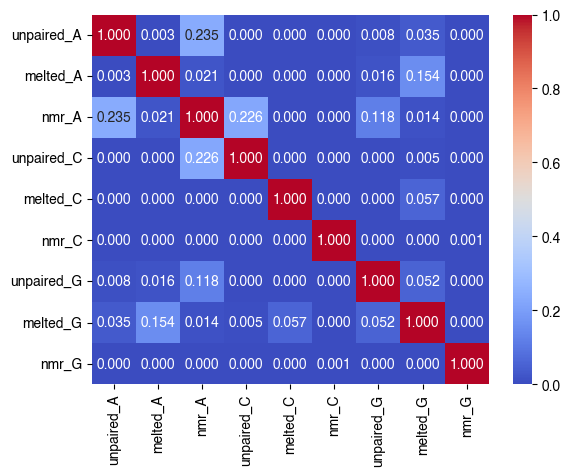

In [ ]:
all_linfits = [unpaired_A, melted_A, nmr_A, unpaired_C, melted_C, nmr_C, unpaired_G, melted_G, nmr_G]

slope_matrix = np.zeros((len(all_linfits), len(all_linfits)))
intercept_matrix = np.zeros((len(all_linfits), len(all_linfits)))

for i in range(len(all_linfits)):
    for j in range(len(all_linfits)):
        welch_slope, welch_int = calc_welch_stats(all_linfits[i], all_linfits[j])
        slope_matrix[i, j] = welch_slope[1]
        intercept_matrix[i, j] = welch_int[1]

sns.heatmap(
    slope_matrix,
    annot=True,
    fmt=".3f",
    cmap='coolwarm',
    xticklabels=['unpaired_A', 'melted_A', 'nmr_A', 'unpaired_C', 'melted_C', 'nmr_C', 'unpaired_G', 'melted_G', 'nmr_G'],
    yticklabels=['unpaired_A', 'melted_A', 'nmr_A', 'unpaired_C', 'melted_C', 'nmr_C', 'unpaired_G', 'melted_G', 'nmr_G']
)

<Axes: >

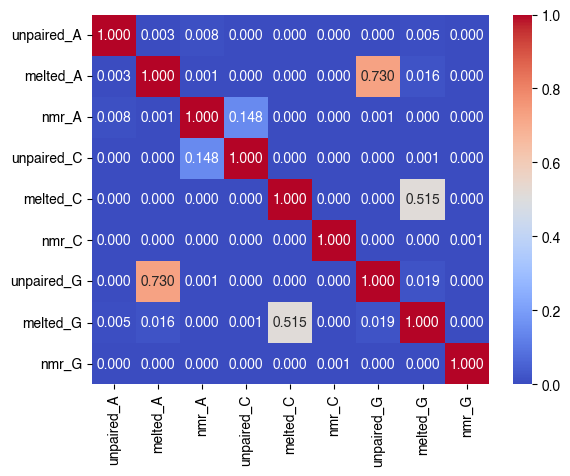

In [ ]:
sns.heatmap(
    intercept_matrix,
    annot=True,
    fmt=".3f",
    cmap='coolwarm',
    xticklabels=['unpaired_A', 'melted_A', 'nmr_A', 'unpaired_C', 'melted_C', 'nmr_C', 'unpaired_G', 'melted_G', 'nmr_G'],
    yticklabels=['unpaired_A', 'melted_A', 'nmr_A', 'unpaired_C', 'melted_C', 'nmr_C', 'unpaired_G', 'melted_G', 'nmr_G']
)

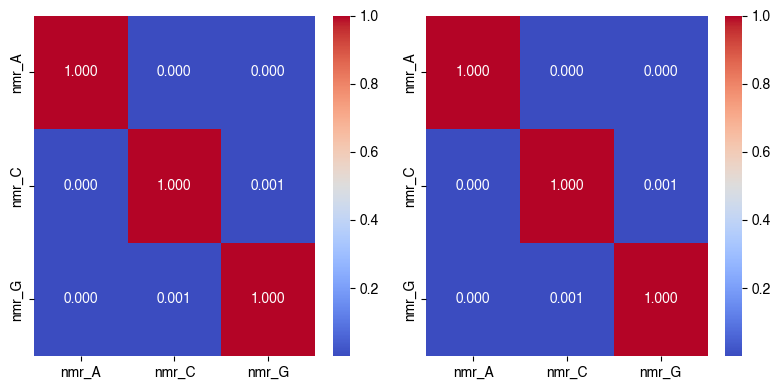

In [ ]:
all_linfits = [nmr_A, nmr_C, nmr_G]

slope_matrix = np.zeros((len(all_linfits), len(all_linfits)))
intercept_matrix = np.zeros((len(all_linfits), len(all_linfits)))

for i in range(len(all_linfits)):
    for j in range(len(all_linfits)):
        welch_slope, welch_int = calc_welch_stats(all_linfits[i], all_linfits[j])
        slope_matrix[i, j] = welch_slope[1]
        intercept_matrix[i, j] = welch_int[1]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

sns.heatmap(
    slope_matrix,
    annot=True,
    fmt=".3f",
    cmap='coolwarm',
    xticklabels=['nmr_A', 'nmr_C', 'nmr_G'],
    yticklabels=['nmr_A', 'nmr_C', 'nmr_G'],
    ax=ax[0]
)

sns.heatmap(
    intercept_matrix,
    annot=True,
    fmt=".3f",
    cmap='coolwarm',
    xticklabels=['nmr_A', 'nmr_C', 'nmr_G'],
    yticklabels=['nmr_A', 'nmr_C', 'nmr_G'],
    ax=ax[1]
)
plt.tight_layout()
plt.show()

In [ ]:
# calculate Ea and ln(A)
from scipy.constants import R, calorie

# Constants
R_val = R / (1000 * calorie)  # kcal/mol/K


save_kadd_params = []

for base in ['A', 'C', 'G']:
    for method in ['nmr', 'unpaired', 'melted_agg']:
        data = all_fits_kobs[(all_fits_kobs['base'] == base) & (all_fits_kobs['method'] == method)]
        linfit_out = fit_linear_model(data)[-1]
        ea_val = -linfit_out.params['slope'].value * R_val  # kcal/mol
        ea_err = linfit_out.params['slope'].stderr * R_val
        lna_val = linfit_out.params['intercept'].value
        lna_err = linfit_out.params['intercept'].stderr

        save_kadd_params.append([base, method, ea_val, ea_err, lna_val, lna_err, linfit_out.rsquared])

# Create DataFrame for saving
kadd_params_df = pd.DataFrame(save_kadd_params, columns=['base', 'method', 'Ea', 'Ea_err', 'lnA', 'lnA_err', 'r_squared'])
kadd_params_df.to_csv('kadd_params.csv', index=False)

In [ ]:

# Fit ANCOVA model: ln(k) ~ invT * method
model = smf.ols('log_kobs ~ inv_temp * C(method, Treatment(reference="nmr"))', data = all_fits_kobs_A).fit() # nmr be reference
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               log_kobs   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     350.6
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           2.58e-39
Time:                        05:11:10   Log-Likelihood:                -19.943
No. Observations:                  59   AIC:                             51.89
Df Residuals:                      53   BIC:                             64.35
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [ ]:
import numpy as np
import pandas as pd
from scipy.constants import R, calorie

# Constants
R_val = R / (1000 * calorie)  # kcal/mol/K

# Base values from NMR (reference group)
slope_nmr = model.params['inv_temp']
slope_err_nmr = model.bse['inv_temp']
intercept_nmr = model.params['Intercept']
intercept_err_nmr = model.bse['Intercept']

# Collect values for each group
groups = ['nmr', 'unpaired']
results = []

for group in groups:
    if group == 'nmr':
        slope = slope_nmr
        slope_err = slope_err_nmr
        intercept = intercept_nmr
        intercept_err = intercept_err_nmr
    else:
        slope = slope_nmr + model.params[f'inv_temp:C(method, Treatment(reference="nmr"))[T.{group}]']
        slope_err = np.sqrt(
            slope_err_nmr**2 +
            model.bse[f'inv_temp:C(method, Treatment(reference="nmr"))[T.{group}]']**2
        )

        intercept = intercept_nmr + model.params[f'C(method, Treatment(reference="nmr"))[T.{group}]']
        intercept_err = np.sqrt(
            intercept_err_nmr**2 +
            model.bse[f'C(method, Treatment(reference="nmr"))[T.{group}]']**2
        )

    Ea = -slope * R_val
    Ea_err = slope_err * R_val

    results.append({
        'group': group,
        'Ea_kcal_per_mol': Ea,
        'Ea_error': Ea_err,
        'lnA': intercept,
        'lnA_error': intercept_err
    })

# Create DataFrame
df_arrhenius = pd.DataFrame(results)
df_arrhenius = df_arrhenius.set_index('group')

df_arrhenius

,Ea_kcal_per_mol,Ea_error,lnA,lnA_error
group,,,,
nmr,15.612292,3.111183,19.674088,5.043299
unpaired,14.227823,4.427967,13.139564,7.177452


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


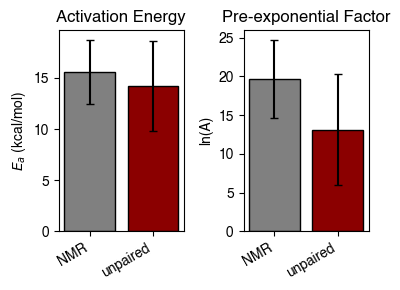

In [ ]:
import matplotlib.pyplot as plt

# Map groups to display names and colors
group_labels = {
    'nmr': 'NMR',
    'unpaired': 'unpaired',
    '4U_a8c': 'DMS (4U A8C)'
}
colors = {
    'nmr': 'gray',
    'unpaired': '#8B0000',   # dark red
    '4U_a8c': '#CD5C5C'   # indian red / lighter red
}

# Get bar positions
groups = ['nmr', 'unpaired']
x = range(len(groups))

fig, axs = plt.subplots(1, 2, figsize=(4, 3), sharey=False)

# Ea bar plot
axs[0].bar(
    x,
    df_arrhenius.loc[groups, 'Ea_kcal_per_mol'],
    yerr=df_arrhenius.loc[groups, 'Ea_error'],
    capsize=3,
    edgecolor='black',
    color=[colors[g] for g in groups]
)
axs[0].set_title('Activation Energy')
axs[0].set_ylabel(r'$E_a$ (kcal/mol)')
axs[0].set_xticks(x)
axs[0].set_xticklabels([group_labels[g] for g in groups], rotation=30, ha='right')

# lnA bar plot
axs[1].bar(
    x,
    df_arrhenius.loc[groups, 'lnA'],
    yerr=df_arrhenius.loc[groups, 'lnA_error'],
    capsize=3,
    edgecolor='black',
    color=[colors[g] for g in groups]
)
axs[1].set_title('Pre-exponential Factor')
axs[1].set_ylabel('ln(A)')
axs[1].set_xticks(x)
axs[1].set_xticklabels([group_labels[g] for g in groups], rotation=30, ha='right')

plt.tight_layout()
plt.savefig('arrhenius_kobs_barplot.pdf')
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


lnkadd_atp20: -6.67644150677047 ± 0.15205076475404636
lnkadd_ctp20: -6.981798003237149 ± 0.3207245387227223
lnkadd_gtp20: -6.272974102461831 ± 0.43844928876100253


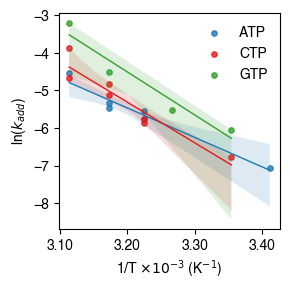

In [ ]:
# PLOT

fig, ax = plt.subplots(figsize=(3, 3))
formatter = FuncFormatter(thousands)

nmr_ntp = pd.read_csv(all_fit_params)
peak8 = nmr_ntp[nmr_ntp['peak'] == 'peak8']
peak8_atp = peak8[peak8['ntp'] == 'ATP']
sns.regplot(x='1/T', y='lnkadd', data=peak8_atp, ax = ax, label='ATP', scatter_kws={'s': 15}, line_kws={'linewidth': 1}, color = sns.color_palette("Paired")[1])

peak8_ctp = peak8[peak8['ntp'] == 'CTP']
sns.regplot(x='1/T', y='lnkadd', data=peak8_ctp, ax = ax, label='CTP', scatter_kws={'s': 15}, line_kws={'linewidth': 1}, color = sns.color_palette("Paired")[5])
peak8_gtp = peak8[peak8['ntp'] == 'GTP']
sns.regplot(x='1/T', y='lnkadd', data=peak8_gtp, ax = ax, label='GTP', scatter_kws={'s': 15}, line_kws={'linewidth': 1}, color = sns.color_palette("Paired")[3])

# Set the x-axis formatter
ax.xaxis.set_major_formatter(formatter)

ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
ax.set_ylabel(r'ln($k_{add}$)')

plt.legend(frameon = False)
plt.tight_layout()
plt.savefig('nmr_ntp_adduction_eyringfit.pdf')

# linear fit
model = lmfit.models.LinearModel()
params = model.guess(peak8_atp['lnkadd'], x=peak8_atp['1/T'])
atp_result = model.fit(peak8_atp['lnkadd'], params, x=peak8_atp['1/T'])
lnkadd_atp20 = atp_result.eval(x = 1 / (298.15))
lnkadd_atp20_err = atp_result.eval_uncertainty(x = 1 / (298.15))

ctp_result = model.fit(peak8_ctp['lnkadd'], params, x=peak8_ctp['1/T'])
lnkadd_ctp20 = ctp_result.eval(x = 1 / (298.15))
lnkadd_ctp20_err = ctp_result.eval_uncertainty(x = 1 / (298.15))

print(f'lnkadd_atp20: {lnkadd_atp20} ± {lnkadd_atp20_err}')
print(f'lnkadd_ctp20: {lnkadd_ctp20} ± {lnkadd_ctp20_err}')

gtp_result = model.fit(peak8_gtp['lnkadd'], params, x=peak8_gtp['1/T'])
lnkadd_gtp20 = gtp_result.eval(x = 1 / (298.15))
lnkadd_gtp20_err = gtp_result.eval_uncertainty(x = 1 / (298.15))
print(f'lnkadd_gtp20: {lnkadd_gtp20} ± {lnkadd_gtp20_err}')